In [2]:
import numpy as np
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
xy = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/data-02-stock_daily.csv', delimiter=',', skiprows=1)


In [5]:
xy[:2]

array([[8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
        8.31659973e+02],
       [8.23020020e+02, 8.28070007e+02, 8.21655029e+02, 1.59780000e+06,
        8.28070007e+02]])

In [6]:
# train, test split
seq_length = 7
train_size = int(len(xy)*0.7)
train_set = xy[:train_size]
test_set = xy[train_size - seq_length:]

print(train_set.shape, test_set.shape)

(512, 5) (227, 5)


In [7]:
def minmax_scaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator + 1e-7)


In [8]:
# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [9]:
train_set[:2]

array([[0.97125436, 0.97337226, 1.        , 0.06773081, 0.98742313],
       [0.95353593, 0.95651845, 0.978622  , 0.10064206, 0.97616367]])

In [10]:
def build_dataset(time_series_data, seq_length):
  data_X = []
  data_y = []
  for i in range(0, len(time_series_data) - seq_length):
    x_ = time_series_data[i: i + seq_length, :]
    y_ = time_series_data[i + seq_length, [-1]]
    data_X.append(x_)
    data_y.append(y_)
  return np.array(data_X), np.array(data_y)

In [11]:
train_X, train_y = build_dataset(train_set, seq_length)
test_X, test_y = build_dataset(test_set, seq_length)

In [12]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


In [13]:
data_dim = 5           # 시각가격, 고가, 저가, 거래량, 종가
hidden_dim = 10
output_dim = 1         # 다음번 주가 에측 값
learning_rate = 0.01
iterations = 500

In [14]:
# numpy 데이터를 tensor로 바꾸기

train_X_tensor = torch.FloatTensor(train_X)
train_y_tensor = torch.FloatTensor(train_y)
test_X_tensor = torch.FloatTensor(test_X)
test_y_tensor = torch.FloatTensor(test_y)

In [15]:
class Net(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(Net, self).__init__()         # 상속 : super
    self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
    self.fc = torch.nn.Linear(hidden_dim, output_dim, bias = True)
  
  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.fc(x[:, -1])
    return x

net = Net(data_dim, hidden_dim, output_dim, 1)

In [16]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [ ]:
# Training

for i in range(iterations):
  optimizer.zero_grad()  
  outputs = net(train_X_tensor)
  loss = criterion(outputs, train_y_tensor)
  loss.backward()
  optimizer.step()
  print(i, loss.item())

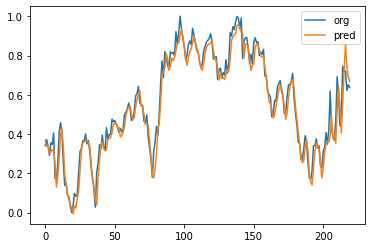

In [18]:
plt.plot(test_y)
plt.plot(net(test_X_tensor).data.numpy())
plt.legend(['org', 'pred'])

plt.show()

In [19]:
# !pip install tensorflow-gpu
import tensorflow as tf
import keras